<a href="https://colab.research.google.com/github/lazybear-0425/EWC_Observation/blob/main/2025-03-23_23_03_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 - Life Lone Learning
 - Elastic Weight Consolidation (EWC)
    - [教學](https://www.kaggle.com/code/hughiephan/elastic-weight-consolidation-on-minst)
    - [Paper](https://arxiv.org/pdf/1612.00796)
    - 公式 $\mathcal{L}(\theta) = \mathcal{L}_B(\theta) + \frac\lambda2\sum^n_{i=1}F_i(\theta_i - \theta^*_{A,i})^2$
        - B是指目前任務，A是指前一個任務
 - [教學2](https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb)

In [142]:
import torch
from torch import nn
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, Lambda
import numpy as np
from torchvision.datasets import MNIST as FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.nn.functional import cross_entropy

In [143]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [144]:
batch_size = 256
epochs = 10
task = 2

 - [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)

In [145]:
def trans_compose(i=0):
    return Compose([
        # lambda x : np.rot90(x, i, axes=[0, 1]).copy(), # 使連續
        # lambda x: np.expand_dims(x, axis=-1),  # 因為ToTensor要PIL or ndarray(H x W x C)，之後轉成Tensor(C x H x W)
        ToTensor(),
        # Lambda(lambda x : x / 255.),
        RandomRotation((90 * i, 90 * i)),
        Normalize(mean=[0.0], std=[1])
    ])

In [146]:
# preprocessing
# train_task_1 = FashionMNIST('data', train=True, transform=trans_compose(0), download=True)
# train_task_2 = FashionMNIST('data', train=True, transform=trans_compose(1), download=True)

test_task_1 = FashionMNIST('data', train=False, transform=trans_compose(0), download=True)
test_task_2 = FashionMNIST('data', train=False, transform=trans_compose(1), download=True)

task_1_loader = DataLoader(test_task_1, batch_size=batch_size)
task_2_loader = DataLoader(test_task_2, batch_size=batch_size)

In [147]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        # self.classifier = nn.Sequential(
        #     nn.Conv2d(1, 10, kernel_size=5),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        #     nn.Conv2d(10, 20, kernel_size=5),
        #     nn.Dropout2d(),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        # )
        # self.dense = nn.Sequential(
        #     nn.Linear(320, 50),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(50, 10)
        # )
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(10)
        )
    def forward(self, X):
        # return self.dense(self.classifier(X).view(-1, 320))
        return self.net(X)

In [148]:
def evaluate(model, dataloader, num_data, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")

    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            test_loss += cross_entropy(output, label)
            test_acc += (output.argmax(1) == label).sum()
    print('\033[33m' +
          f'Task {num_task} Acc: {test_acc / num_data: .4f}, Loss: {test_loss / num_data: .4f}' +
          '\033[0m')

In [149]:
def training_Setting(model):
    optimizer = Adam(model.parameters())
    loss = CrossEntropyLoss()
    return optimizer, loss

 - Fisher Matrix
     - 儲存權重對模型重要性
     - 計算方法
         - [LINK](https://github.com/db434/EWC)
             - 這個版本是**取樣** $\rightarrow$ 計算梯度
         - 這邊的範例程式碼是直接**整個資料**來計算梯度
         - 公式
             - $F_j = \frac1m \sum^m_{i=1}(\frac{\partial \log (P(x_i|\theta_j))}{\partial \theta_j})^2$

In [150]:
# EWC
optim_para = {}
fisher_matrix = {}
ewc_lambda = 25

def record_parameter(model, train_data, optimizer, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model.train()
    optimizer.zero_grad()

    fisher_matrix[num_task] = {}
    optim_para[num_task] = {}

    # Initialize Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] = torch.zeros_like(param.data)

    # Calculate Fisher Matrix
    for data in train_loader:
        img, label = data
        img, label = img.to(device), label.to(device).long()
        output = model(img)
        output_loss = cross_entropy(output, label)
        output_loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_matrix[num_task][name] += param.grad.data.clone().pow(2)

    # Average Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] /= len(train_loader)

    # Save optimal parameters
    for name, param in model.named_parameters():
        optim_para[num_task][name] = param.data.clone()

In [151]:
def training(model, test_loader : list, test_num : list, epochs = 10,  num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    print(f'Task {num_task} Start!')

    train_data = FashionMNIST('data', train=True, transform=trans_compose(num_task), download=True)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # plt.imshow(train_data[0][0].reshape(28, 28), cmap='gray')
    # plt.title('Task' + str(num_task))
    # plt.show()

    # optimizer, loss = training_Setting(model)
    optimizer = SGD(model.parameters())

    for i in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0
        for data in train_loader:
            optimizer.zero_grad()

            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            output_loss = cross_entropy(output, label)
            # Record
            train_acc += (output.argmax(1) == label).sum()
            # BP
            ewc_loss = 0
            for t in range(num_task):
                for name, param in model.named_parameters():
                    if t in optim_para:
                        fisher = fisher_matrix[t][name]
                        optim = optim_para[t][name]
                        if fisher.requires_grad == True or optim.requires_grad == True:
                            raise NotImplementedError('Frozen it!')
                        # output_loss += ewc_lambda * (fisher * (optim - param).pow(2)).sum() # .detach()
                        ewc_loss += (fisher * (optim - param).pow(2)).sum() * ewc_lambda
            # if tmp != 0: print(tmp)
            output_loss += ewc_loss
            train_loss += output_loss.detach()
            output_loss.backward()
            optimizer.step()
        print(f'Epoch\t{i + 1}\tAcc: {train_acc / len(train_data): .4f}, Loss: {train_loss / len(train_data): .4f}')
    record_parameter(model, train_data, optimizer, num_task=num_task)
    # Evaluate Task 0 & 1
    task_id = 0
    for num_data, loader in zip(test_num, test_loader):
        evaluate(model, loader, num_data, task_id)
        task_id = task_id + 1
    print() # End of Training

 - nn.Module
    - named_pa​​rameters()
         - 給出網絡層的名字和參數的迭代器
    - parameters()
         - 參數的迭代器
    - [Reference](https://blog.csdn.net/qq_36530992/article/details/102729585)

In [152]:
model = Module().to(device)

for i in range(task):
    training(model, [task_1_loader, task_2_loader], [len(test_task_1), len(test_task_2)], num_task=i, epochs=epochs)

Task 0 Start!
Epoch	1	Acc:  0.2932, Loss:  0.0085
Epoch	2	Acc:  0.5900, Loss:  0.0077
Epoch	3	Acc:  0.6921, Loss:  0.0070
Epoch	4	Acc:  0.7313, Loss:  0.0065
Epoch	5	Acc:  0.7531, Loss:  0.0060
Epoch	6	Acc:  0.7685, Loss:  0.0056
Epoch	7	Acc:  0.7800, Loss:  0.0052
Epoch	8	Acc:  0.7886, Loss:  0.0049
Epoch	9	Acc:  0.7959, Loss:  0.0047
Epoch	10	Acc:  0.8018, Loss:  0.0045
Task 0 Acc:  0.8174, Loss:  0.0044
Task 1 Acc:  0.0957, Loss:  0.0098

Task 1 Start!
Epoch	1	Acc:  0.1043, Loss:  0.0093
Epoch	2	Acc:  0.1225, Loss:  0.0091
Epoch	3	Acc:  0.1371, Loss:  0.0090
Epoch	4	Acc:  0.1513, Loss:  0.0089
Epoch	5	Acc:  0.1640, Loss:  0.0088
Epoch	6	Acc:  0.1759, Loss:  0.0088
Epoch	7	Acc:  0.1862, Loss:  0.0087
Epoch	8	Acc:  0.1956, Loss:  0.0087
Epoch	9	Acc:  0.2051, Loss:  0.0086
Epoch	10	Acc:  0.2145, Loss:  0.0086
Task 0 Acc:  0.8103, Loss:  0.0044
Task 1 Acc:  0.2184, Loss:  0.0084



 - Task 0

Accuracy 0.8103
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.83      0.94      0.88       980
     1 - one       0.86      0.94      0.90      1135
     2 - two       0.78      0.77      0.78      1032
   3 - three       0.68      0.89      0.77      1010
    4 - four       0.86      0.78      0.82       982
    5 - five       0.93      0.48      0.63       892
     6 - six       0.83      0.87      0.85       958
   7 - seven       0.89      0.83      0.86      1028
   8 - eight       0.78      0.76      0.77       974
    9 - nine       0.77      0.78      0.77      1009

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.80     10000
weighted avg       0.82      0.81      0.81     10000



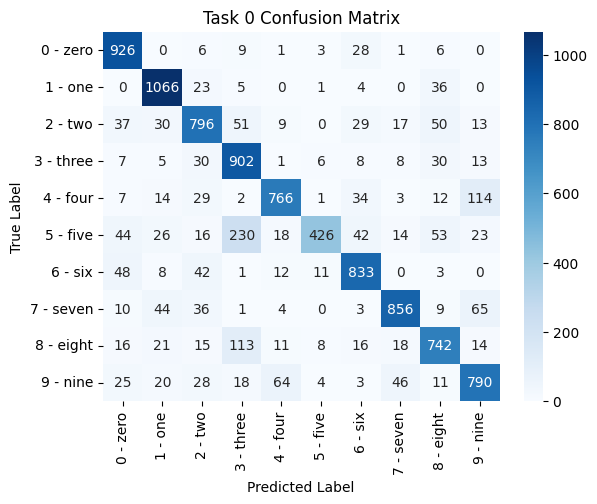

In [153]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_1_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_1.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_1.classes, yticklabels=test_task_1.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 0 Confusion Matrix")
plt.show()

 - Task 1

Accuracy 0.2184
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.33      0.72      0.45       980
     1 - one       0.00      0.00      0.00      1135
     2 - two       0.21      0.20      0.21      1032
   3 - three       0.06      0.04      0.05      1010
    4 - four       0.07      0.11      0.08       982
    5 - five       0.03      0.01      0.01       892
     6 - six       0.24      0.17      0.20       958
   7 - seven       0.27      0.42      0.33      1028
   8 - eight       0.38      0.33      0.35       974
    9 - nine       0.23      0.20      0.21      1009

    accuracy                           0.22     10000
   macro avg       0.18      0.22      0.19     10000
weighted avg       0.18      0.22      0.19     10000



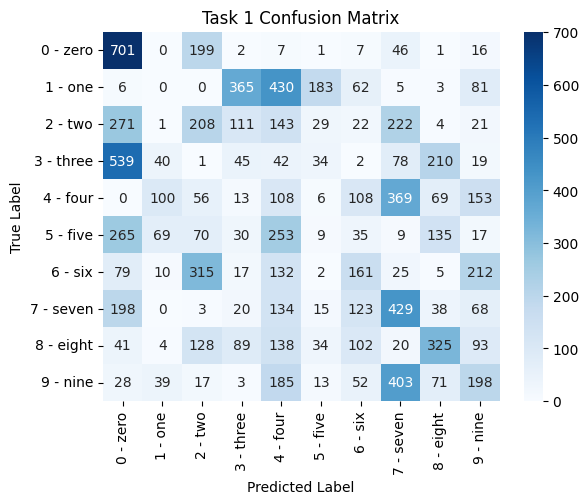

In [154]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_2_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_2.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_2.classes, yticklabels=test_task_2.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 1 Confusion Matrix")
plt.show()

net.1.weight
torch.Size([10, 784])
Max fisher is 9.52896 and it's parameter diff is 0.00008
Min Parameter diff is 0.06293 and it's fisher is 0.00074
fisher > parameter diff: 497
fisher <= parameter diff: 287


<Figure size 640x480 with 0 Axes>

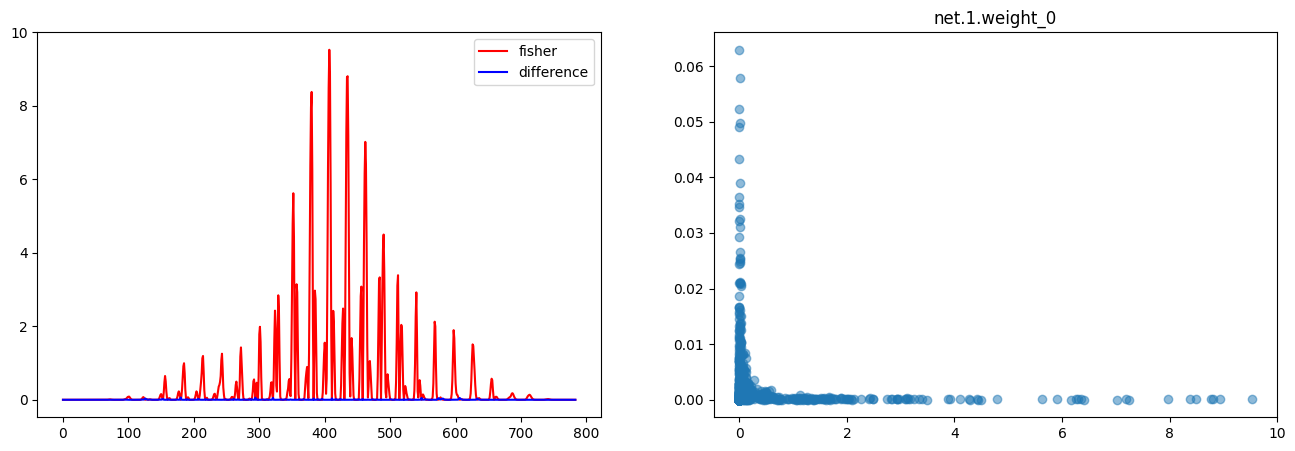

Max fisher is 18.97737 and it's parameter diff is 0.00008
Min Parameter diff is 0.03915 and it's fisher is 0.00444
fisher > parameter diff: 514
fisher <= parameter diff: 270


<Figure size 640x480 with 0 Axes>

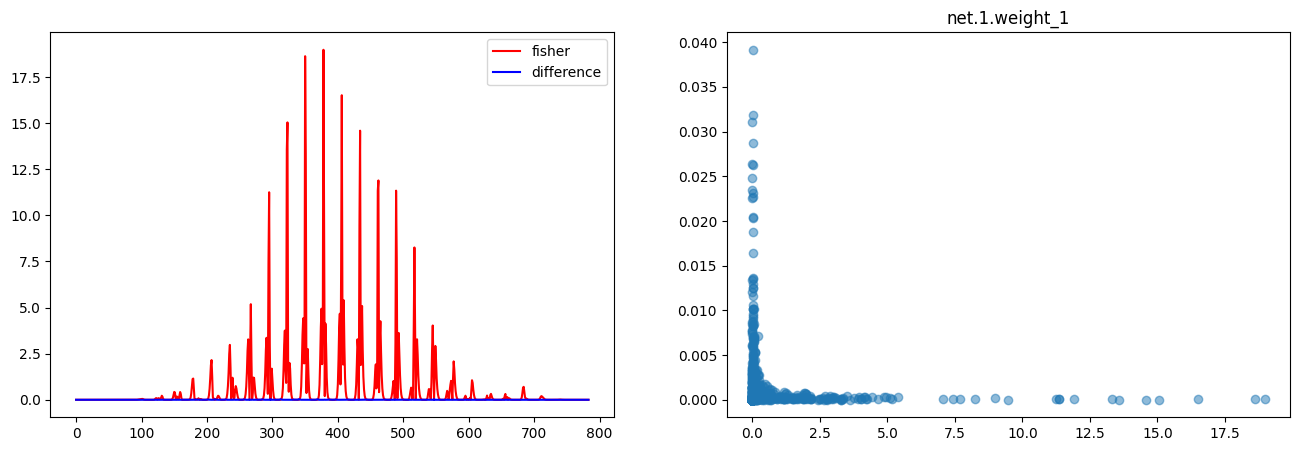

Max fisher is 6.10812 and it's parameter diff is 0.00003
Min Parameter diff is 0.05227 and it's fisher is 0.00057
fisher > parameter diff: 507
fisher <= parameter diff: 277


<Figure size 640x480 with 0 Axes>

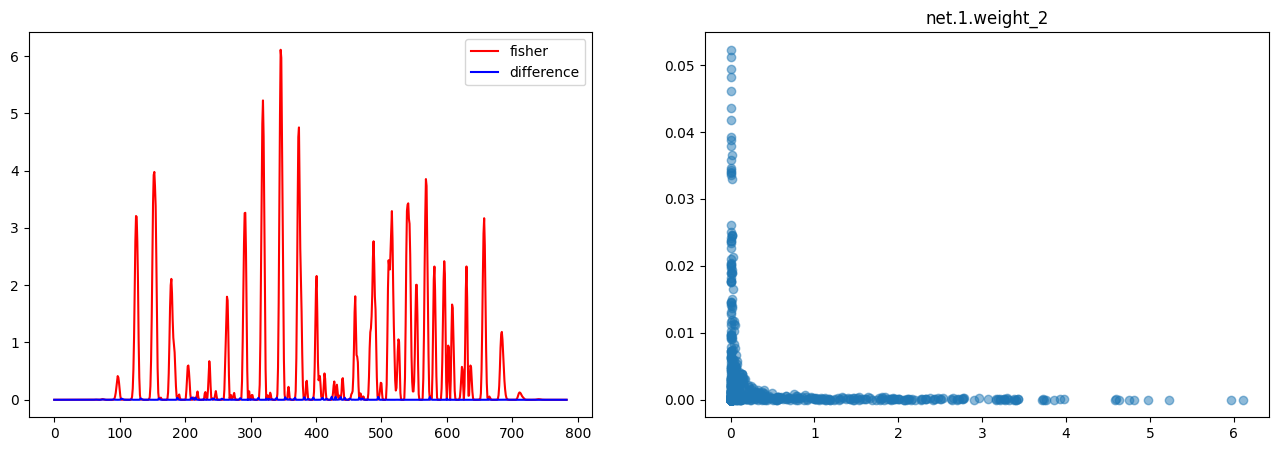

Max fisher is 6.11766 and it's parameter diff is 0.00005
Min Parameter diff is 0.08258 and it's fisher is 0.00173
fisher > parameter diff: 502
fisher <= parameter diff: 282


<Figure size 640x480 with 0 Axes>

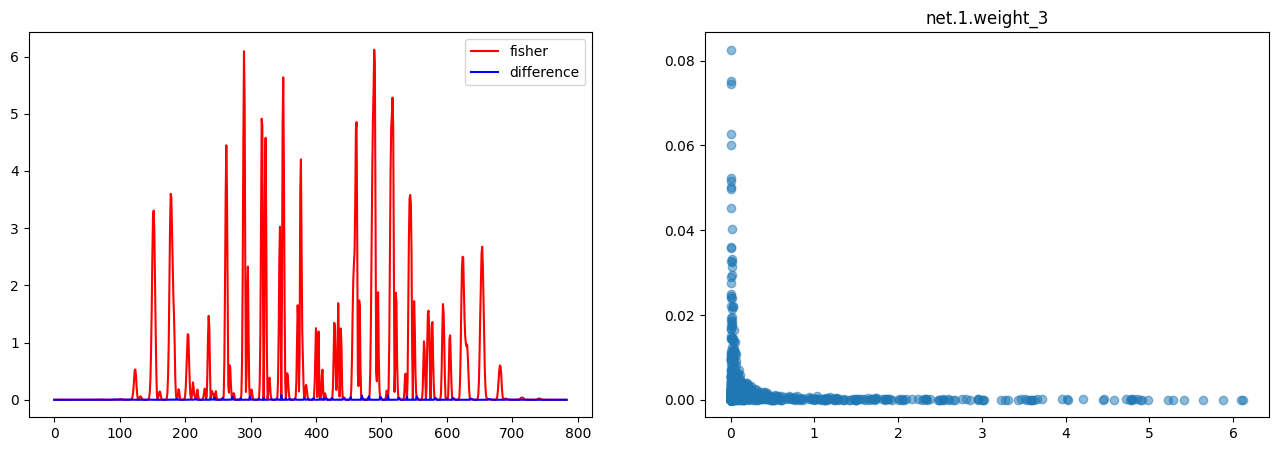

Max fisher is 9.12052 and it's parameter diff is 0.00003
Min Parameter diff is 0.07047 and it's fisher is 0.00405
fisher > parameter diff: 472
fisher <= parameter diff: 312


<Figure size 640x480 with 0 Axes>

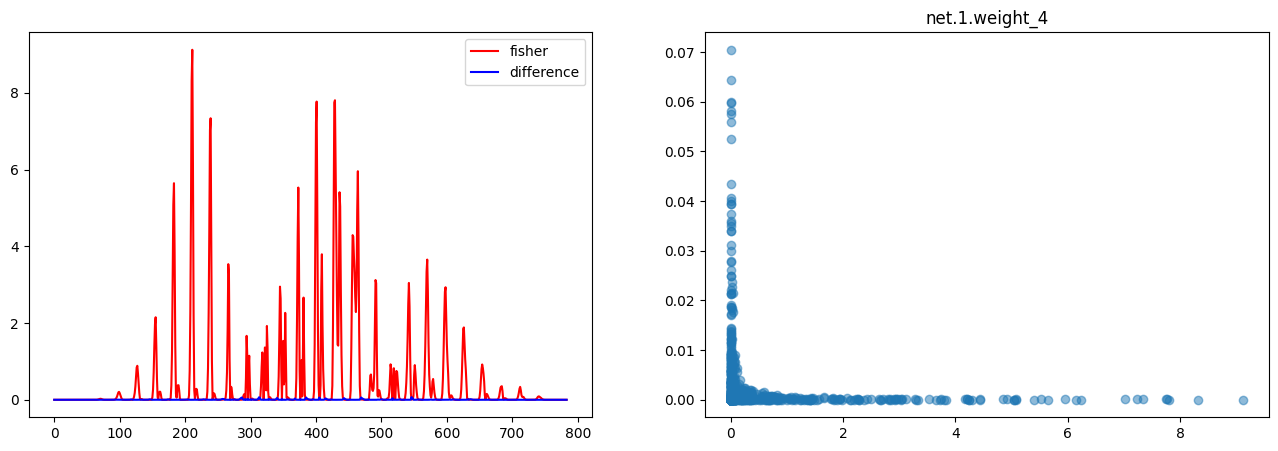

Max fisher is 6.91957 and it's parameter diff is 0.00005
Min Parameter diff is 0.03887 and it's fisher is 0.00265
fisher > parameter diff: 496
fisher <= parameter diff: 288


<Figure size 640x480 with 0 Axes>

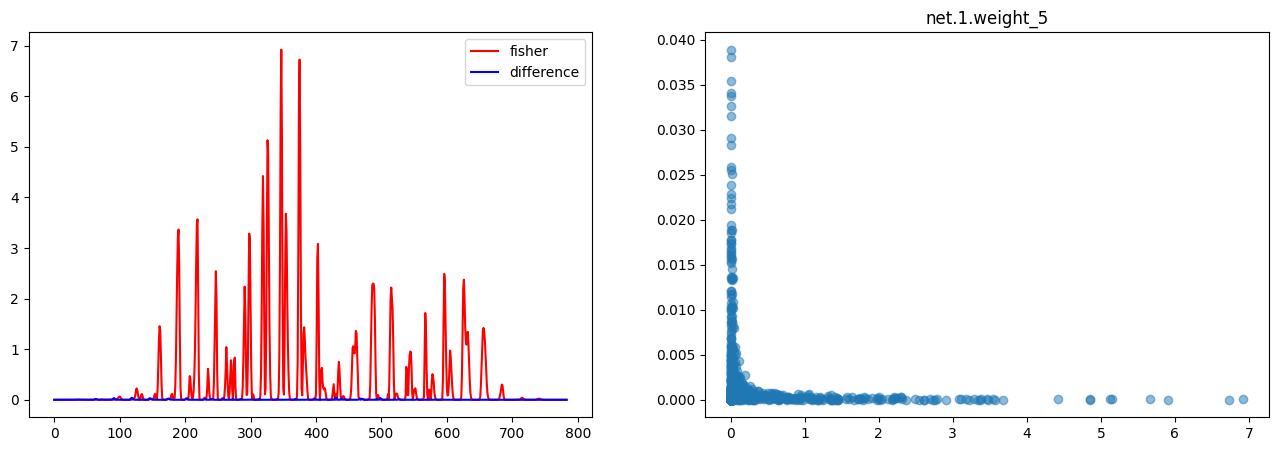

Max fisher is 9.60669 and it's parameter diff is 0.00002
Min Parameter diff is 0.07179 and it's fisher is 0.00261
fisher > parameter diff: 520
fisher <= parameter diff: 264


<Figure size 640x480 with 0 Axes>

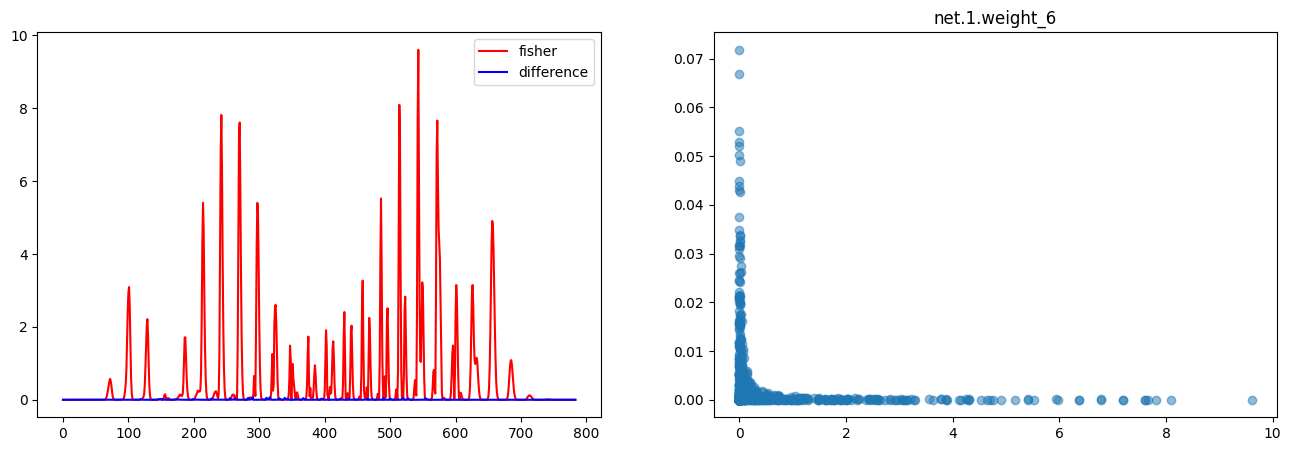

Max fisher is 8.73376 and it's parameter diff is 0.00007
Min Parameter diff is 0.06900 and it's fisher is 0.00579
fisher > parameter diff: 518
fisher <= parameter diff: 266


<Figure size 640x480 with 0 Axes>

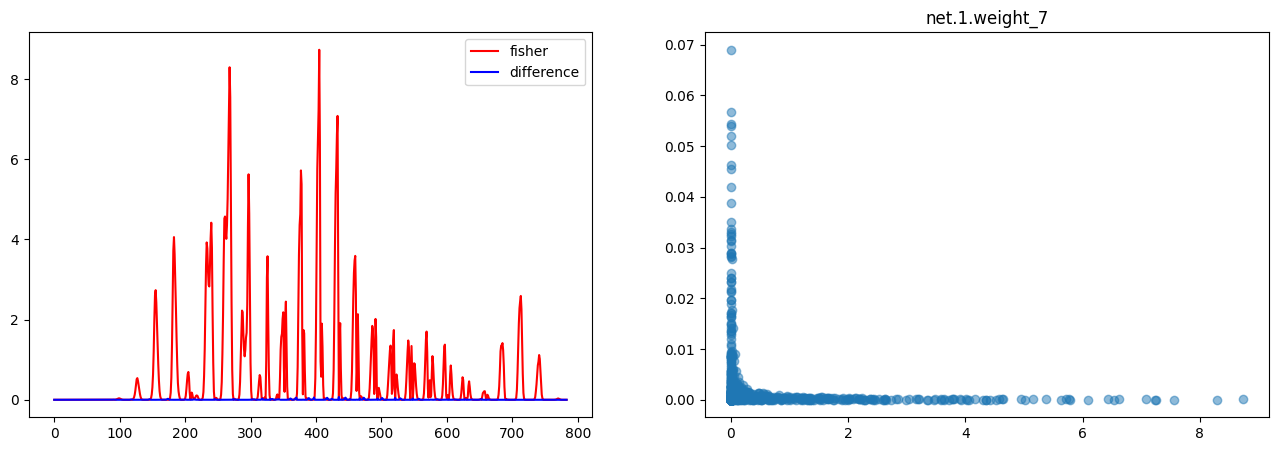

Max fisher is 5.04217 and it's parameter diff is 0.00003
Min Parameter diff is 0.04988 and it's fisher is 0.00015
fisher > parameter diff: 502
fisher <= parameter diff: 282


<Figure size 640x480 with 0 Axes>

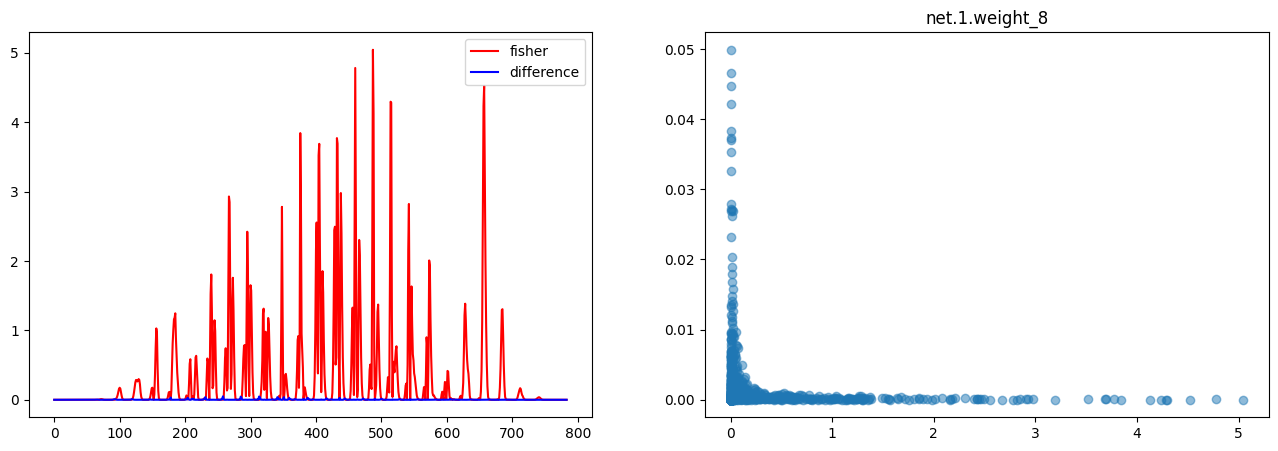

Max fisher is 8.58877 and it's parameter diff is 0.00003
Min Parameter diff is 0.04106 and it's fisher is 0.00142
fisher > parameter diff: 509
fisher <= parameter diff: 275


<Figure size 640x480 with 0 Axes>

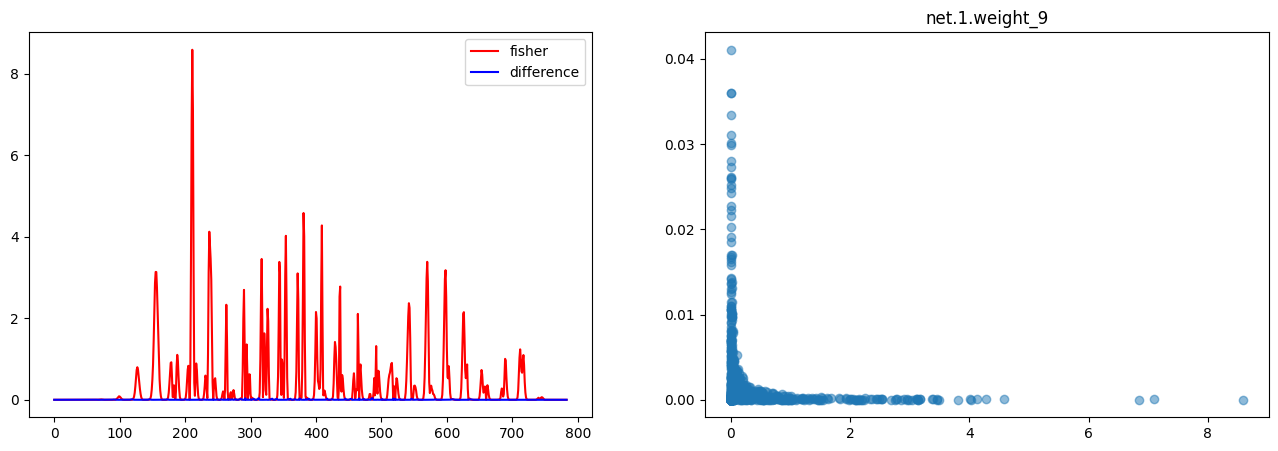


net.1.bias
torch.Size([10])
Max fisher is 3.89869 and it's parameter diff is 0.00028
Min Parameter diff is 0.01610 and it's fisher is 0.01183
fisher > parameter diff: 9
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

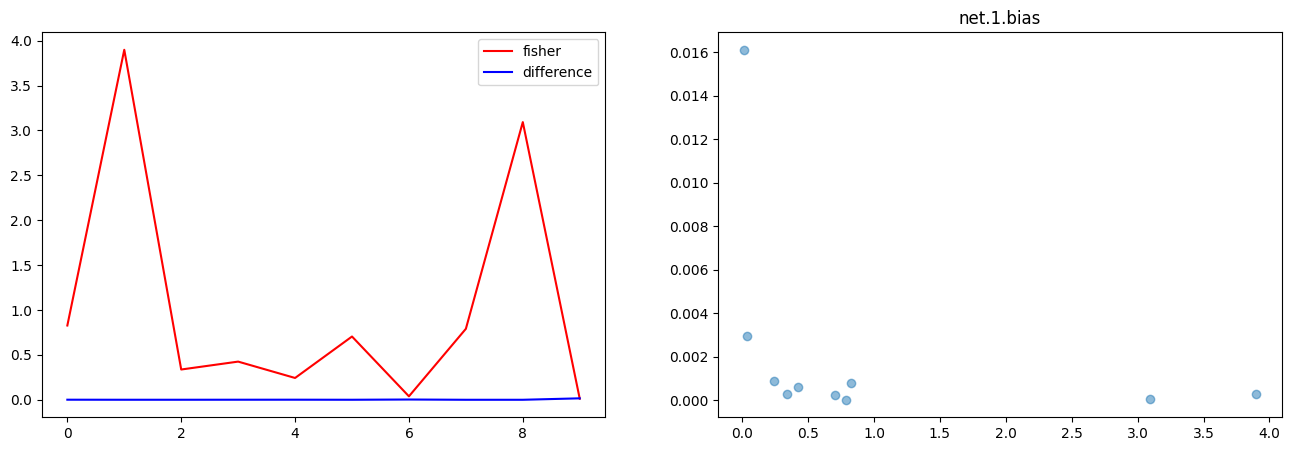

In [155]:
def plot(fisher_matrix, optim_para, param, name):
  plt.cla(); plt.clf()
  #print(fisher_matrix.shape, optim_para.shape, param.shape)
  fisher = fisher_matrix.cpu().detach()
  optim = optim_para.cpu().detach()
  param = param.cpu().detach()

  fisher_max = np.argmax(fisher)
  param_diff_max = np.argmax((optim - param).abs())
  print(f'Max fisher is {fisher[fisher_max]:.5f} and it\'s parameter diff is {(optim - param).abs()[fisher_max]:.5f}')
  print(f'Min Parameter diff is {(optim - param).abs()[param_diff_max]:.5f} and it\'s fisher is {fisher[param_diff_max]:.5f}')
  # compare
  print('fisher > parameter diff: {}'.format((fisher > (optim - param).abs()).sum()))
  print('fisher <= parameter diff: {}'.format((fisher <= (optim - param).abs()).sum()))

  # plot
  fig, ax = plt.subplots(1, 2, figsize=(16, 5)) # row, col
  ax[0].plot(fisher.reshape(-1), 'r', label='fisher')
  ax[0].plot((optim - param).abs().reshape(-1), 'b', label='difference')
  ax[0].legend()

  ax[1].scatter(fisher, (optim - param).abs().reshape(-1), alpha=0.5)
  plt.title(name)
  plt.show()

# test
idx = 0
for name, param in model.named_parameters():

  # Name
  print(name)
  print(param.detach().shape)

  if len(param.detach().shape) != 1:
    for i in range(param.detach().shape[0]):
      plot(fisher_matrix[0][name][i], optim_para[0][name][i], param[i], f'{name}_{i}')
  else:
    plot(fisher_matrix[0][name], optim_para[0][name], param, name)
  # END
  idx += 1
  print()

In [156]:
import datetime
import pytz

now = datetime.datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d_%H_%M_%S")
print(now)

2025-03-23_23_03_30
